In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


Image size (H, W) is: (2048, 1536)
Data type of image is: uint8
[[255 255 255 ... 244 243 241]
 [255 255 255 ... 244 242 240]
 [255 255 255 ... 243 242 241]
 ...
 [105 107 108 ... 120 122 121]
 [105 105 106 ... 118 121 119]
 [104 104 104 ... 121 123 120]]


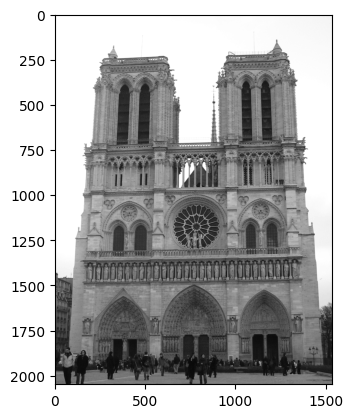

In [7]:
img = cv2.imread(r"C:\Users\hadee\Desktop\computer_vision\notre_dame_1.jpg", 0)
# print the size  of image
print("Image size (H, W) is:",img.shape)
# print data-type of image
print("Data type of image is:",img.dtype)
print(img)
plt.imshow(img, cmap="gray")

In [9]:
# Alpha blending of two images
def alphaBlend(f, g, alpha):
    return (1 - alpha) * f + alpha * g

In [11]:
def histogramEqualization(f, bins=100):
    his, be = histogram(f, range=(0,1), bins=bins)
    his = his.astype(float)/sum(his)
    return interp(f, be, hstack((zeros((1)), cumsum(his))))

In [15]:
from cv2 import warpPerspective

In [28]:
from skimage.transform import warp
def rotation_matrix(f, angle):
        M,N = f.shape[:2]
        T = np.array([[1, 0, M/2],
                     [0, 1, N/2],
                     [0, 0, 1  ]])
        ca = np.cos(angle)
        sa = np.sin(angle)
        R = np.array([[ca, -sa, 0],
                   [sa,  ca, 0],
                   [ 0,   0, 1]])
        return T @ R @ np.linalg.inv(T)


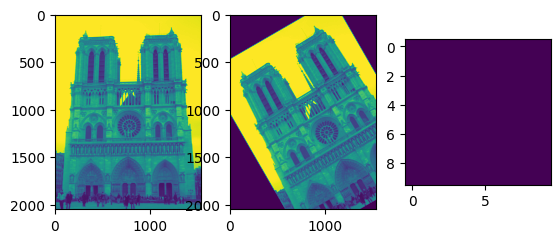

In [30]:
img = cv2.imread(r"C:\Users\hadee\Desktop\computer_vision\notre_dame_1.jpg", 0)
plt.subplot(131); plt.imshow(a);
d = warp(a, rotation_matrix(a, np.pi/6))
plt.subplot(132); plt.imshow(d)
plt.subplot(133); plt.imshow(d[:10,:10])
plt.show()

# Bag of words  

In [31]:
# Plot histogram
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()                      

In [35]:
# Read image
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

In [36]:
# Compute image descriptors
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des


In [37]:
# Compute BOVW features for image
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

In [38]:
# Normalize the image features
def normalizeFeatures(scale, features):
    return scale.transform(features)

In [43]:
img_path= r"C:\Users\hadee\Desktop\computer_vision\notre_dame_1.jpg"
im= readImage(img_path)

In [51]:
# Extract SIFT features and quantized labels
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(im, None)
labels = cv2.kmeans(descriptors, 10)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'kmeans'
> Overload resolution failed:
>  - kmeans() missing required argument 'bestLabels' (pos 3)
>  - kmeans() missing required argument 'bestLabels' (pos 3)


In [52]:
def generate_bovw_spatial_histogram(im, locations, clusters, division):

    # Convert the image to grayscale
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Extract SIFT features from the image
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(im_gray, None)

    # Create a dictionary of visual words using k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = clusters.size
    ret, labels, (centers) = cv2.kmeans(descriptors, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Compute the spatial histogram of visual words
    hist = np.zeros(division[0] * division[1], dtype=np.int64)
    for i in range(locations.shape[0]):
        bin_idx = (locations[i, 1] // (im.shape[0] // division[0])) * division[1] + (locations[i, 0] // (im.shape[1] // division[1]))
        hist[bin_idx] += clusters[i]

    return hist

In [57]:
import numpy as np
import cv2

def sift_features(im):

    # Convert the image to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()

    # Detect the SIFT features in the image
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Convert the keypoints to a list of (x, y) tuples
    sift_features = [(kp.pt[0], kp.pt[1]) for kp in keypoints]

    return sift_features, descriptors



In [58]:
def generate_bovw_spatial_histogram(im, locations, clusters, division):

    # Compute the SIFT features and descriptors for the image
    sift_features, descriptors = sift_features(im)

    # Initialize the BoVW vocabulary
    vocabulary = cv2.kmeans_init(descriptors, clusters)
    vocabulary, labels, _ = cv2.kmeans(descriptors, clusters, None, None, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Initialize the spatial histogram
    hist = np.zeros((division[0], division[1]), dtype=np.int64)

    # Compute the spatial histogram
    for i, (x, y) in enumerate(locations):
        # Quantize the feature to its nearest visual word
        cluster_id = labels[i]

        # Map the cluster id to its corresponding bin in the spatial histogram
        bin_x = x // (im.shape[1] // division[1])
        bin_y = y // (im.shape[0] // division[0])
        hist[bin_y, bin_x] += cluster_id

    return hist.flatten()

In [59]:
img_path= r"C:\Users\hadee\Desktop\computer_vision\notre_dame_1.jpg"
im= readImage(img_path)
sift_features, descriptors = sift_features(im)
locations = np.array(sift_features, dtype=np.int64)
generate_bovw_spatial_histogram(im, locations, 5, [1,2])

error: OpenCV(4.9.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


## Trainning RSnet

In [62]:
# display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [64]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 5s 0us/step


In [65]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [74]:
import torchvision
from torchvision import transforms,datasets
image_transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_generator=torchvision.datasets.ImageFolder(r"C:\Users\hadee\Desktop\computer_vision\coursework\EXCV10\train",transform=image_transform)
valid_generator=torchvision.datasets.ImageFolder(r"C:\Users\hadee\Desktop\computer_vision\coursework\EXCV10\val")

In [75]:
def trainModel(model, epochs, optimizer):
    batch_size = 64
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [76]:
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>

In [ ]:
#loos
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

In [ ]:
#accuracy
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [ ]:
#evaluate
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

In [ ]:
#Test in new data
img = tf.keras.preprocessing.image.load_img('/workspace/tulipe-test.jpeg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [ ]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

In [ ]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

In [ ]:
# transform classes number into classes name
class_names[class_id.item()]

In [ ]:
#save 
model.save('/workspace/saved_model/my_model')

In [ ]:
# my_model directory
%ls /workspace/saved_model/

In [ ]:
# contains an assets folder, saved_model.pb, and variables folder
%ls /workspace/saved_model/my_model

In [ ]:
model = tf.keras.models.load_model('/workspace/saved_model/my_model')
model.summary()